In [17]:
import sqlite3
import os
import pandas as pd
import streamlit as st
import time
import matplotlib.pyplot as plt

connexion = sqlite3.connect("../database/bce.db")
cursor = connexion.cursor()

2022-10-27 12:23:52.776 INFO    matplotlib.font_manager: Failed to extract font properties from /usr/share/fonts/truetype/noto/NotoColorEmoji.ttf: In FT2Font: Can not load face (unknown file format; error code 0x2)
2022-10-27 12:23:52.963 INFO    matplotlib.font_manager: generated new fontManager


In [2]:
# creating dataframe for entreprise table
cursor.execute("""
Select *
FROM enterprise
""")
enterprise = cursor.fetchall()
col = [description[0] for description in cursor.description]

df_enterprise = pd.DataFrame.from_records(data=enterprise, columns=col)

In [20]:
# creating dataframe for type of enterprise
cursor.execute("""
select * 
from code
where Category = 'TypeOfEnterprise'
""")
data = cursor.fetchall()
col = [description[0] for description in cursor.description]

df_type_of_enterprise = pd.DataFrame.from_records(data=data, columns=col)
df_type_of_enterprise_FR = df_type_of_enterprise.drop(df_type_of_enterprise[df_type_of_enterprise.Language == 'NL'].index)
df_type_of_enterprise_FR

,Category,Code,Language,Description
0,TypeOfEnterprise,0,FR,Inconnu
2,TypeOfEnterprise,1,FR,Personne physique
4,TypeOfEnterprise,2,FR,Personne morale


In [3]:
nbr_of_enterprises = df_enterprise.shape[0]
nbr_of_enterprises

1863292

In [6]:
# Check no duplicates
df_enterprise.duplicated().value_counts()

False    1863292
dtype: int64

In [30]:
df_enterprise.head()

,EnterpriseNumber,Status,JuridicalSituation,TypeOfEnterprise,JuridicalForm,StartDate
0,0200.065.765,AC,000,2,416,1960-08-09 00:00:00
1,0200.068.636,AC,000,2,417,1923-02-16 00:00:00
2,0200.171.970,AC,000,2,116,1968-01-01 00:00:00
3,0200.245.711,AC,012,2,116,1922-01-01 00:00:00
4,0200.305.493,AC,000,2,416,1922-01-01 00:00:00


In [72]:
type(df_enterprise.at[0, 'TypeOfEnterprise'])

str

In [11]:
# How many companies per status
status = df_enterprise['Status'].value_counts()

AC    1863292
Name: Status, dtype: int64

In [4]:
groupby_status = df_enterprise.groupby(['Status']).count()
groupby_status

,EnterpriseNumber,JuridicalSituation,TypeOfEnterprise,JuridicalForm,StartDate
Status,,,,,
AC,1863292,1863292,1863292,1099649,1863291


In [9]:
status_percent = groupby_status['EnterpriseNumber'] / nbr_of_enterprises * 100
status_percent['AC']

100.0

In [83]:
# define query executor function
def run_query(query):
    cursor.execute(query)
    return cursor.fetchall()

In [84]:
start_time = time.time()

rows = run_query('''
    select count(EnterpriseNumber) as nbr_entreprises, Status 
    from enterprise 
    group by Status
   ''')

end_time = time.time()
print(f"Query Complete - Elapsed {(end_time - start_time)} secs.")

Query Complete - Elapsed 0.5079777240753174 secs.


In [18]:
#"Which percentage of the companies are which type of entreprise?"
groupby_type = df_enterprise.groupby(['TypeOfEnterprise']).count()
groupby_type

,EnterpriseNumber,Status,JuridicalSituation,JuridicalForm,StartDate
TypeOfEnterprise,,,,,
1,763643,763643,763643,0,763643
2,1099649,1099649,1099649,1099649,1099648


In [54]:
desc = df_type_of_enterprise_FR.loc[df_type_of_enterprise_FR['Code'] == '2']['Description']
type(desc.values[0])

str

In [85]:
cols = ['nbr_enterprises', 'status']
df_status = pd.DataFrame(rows, columns=cols)
df_status

,nbr_enterprises,status
0,1863292,AC


In [87]:
df_status['percent'] = df_status['nbr_enterprises'] / df_status['nbr_enterprises'].sum() * 100
df_status['percent']

0    100.0
Name: percent, dtype: float64

In [93]:
percent = str(df_status.at[0, 'percent']) + '%'
percent

'100.0%'

In [67]:
start_time = time.time()

rows = run_query('''
    select count(enterprise.EnterpriseNumber), TypeOfEnterprise.Description
from enterprise
left join (Select Code, Description
	from code
	where code.Category = "TypeOfEnterprise" AND code."Language"="FR")  TypeOfEnterprise
on enterprise.TypeOfEnterprise = TypeOfEnterprise.Code
group by TypeOfEnterprise.Description
   ''')

end_time = time.time()
print(f"Query Complete - Elapsed {(end_time - start_time)} secs.")


Query Complete - Elapsed 3.460869073867798 secs.


In [68]:
cols = ['enterprise_count', 'type_desc']
df_entreprise_type_count = pd.DataFrame(rows, columns=cols)
df_entreprise_type_count

,enterprise_count,type_desc
0,1099649,Personne morale
1,763643,Personne physique


In [74]:
df_entreprise_type_count['percent'] = df_entreprise_type_count['enterprise_count'] / df_entreprise_type_count['enterprise_count'].sum() * 100
df_entreprise_type_count

,enterprise_count,type_desc,percent
0,1099649,Personne morale,59.016461
1,763643,Personne physique,40.983539


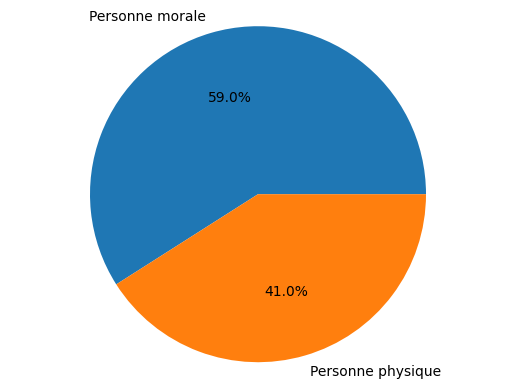

In [81]:
# ploting % enterprise type
fig, ax = plt.subplots()
ax.pie(df_entreprise_type_count['percent'], labels=df_entreprise_type_count['type_desc'],
autopct='%1.1f%%')
ax.axis('equal') 
plt.show()

In [25]:
# Nbr of entitys in Belgium
start_time = time.time()

rows = run_query('''
    select 'Branch' as Type,  COUNT(Id) as Nbr
    from branch
    union
    select 'Establishment', COUNT(EstablishmentNumber)
    from establishment
    union
    select 'Enterprise', count(EnterpriseNumber)
    from enterprise
    order by Nbr desc
   ''')

end_time = time.time()
print(f"Query Complete - Elapsed {(end_time - start_time)} secs.")

Query Complete - Elapsed 0.45177578926086426 secs.


In [31]:
cols = ['entity_type', 'nbr']
df_entity_type_count = pd.DataFrame(rows, columns=cols)
df_entity_type_count

,entity_type,nbr
0,Enterprise,1863292
1,Establishment,1599835
2,Branch,7438


/tmp/ipykernel_8228/2577460684.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels([f'{x:,}' for x in current_values])
/tmp/ipykernel_8228/2577460684.py:16: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b = True, color ='black',


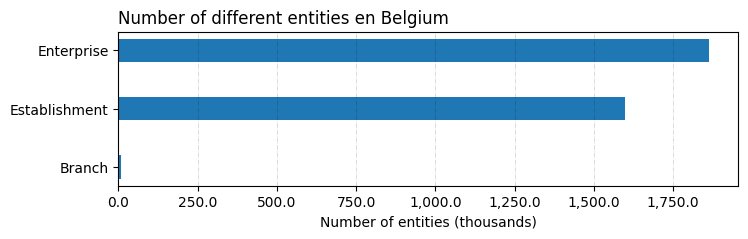

In [66]:
# bar chart for types of entities
fig_entities, ax = plt.subplots(figsize =(8, 2))
 
# creating the bar plot
ax.barh(df_entity_type_count['entity_type'], df_entity_type_count['nbr'], data=df_entity_type_count, height=0.4)

# reoder from highest to lowest
ax.invert_yaxis()

# after plotting the data, format the labels in thousands
current_values = plt.gca().get_xticks() / 1000
# using format string '{:.0f}' here but you can choose others
plt.gca().set_xticklabels([f'{x:,}' for x in current_values])

# Add x, y gridlines
ax.grid(b = True, color ='black',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2, axis='x')

ax.set_xlabel("Number of entities (thousands)")
ax.set_title("Number of different entities in Belgium", loc='left')
plt.show()

In [14]:
# Countries with branches in Belium
start_time = time.time()

rows = run_query('''
    select a.CountryFR, count(b.EnterpriseNumber) as Nbr  
from branch b, address a
where b.EnterpriseNumber = a.EntityNumber
group by a.CountryFR
order by Nbr desc 
   ''')

end_time = time.time()
print(f"Query Complete - Elapsed {(end_time - start_time)} secs.")

Query Complete - Elapsed 1.0542807579040527 secs.


In [15]:
cols = ['country', 'nbr of enterprises']
df_enterprises_by_country = pd.DataFrame(rows, columns=cols)
df_enterprises_by_country

,country,nbr of enterprises
0,Grande-Bretagne,1685
1,Pays-Bas,1452
2,France,1137
3,Etats-Unis d'Amérique,821
4,Allemagne (Rép.féd.),500
...,...,...
133,Antilles britanniques,1
134,Antilles américaines,1
135,Anguilla(R.U.),1
136,Allemagne,1


---

In [45]:
new_df = pd.merge(df_enterprise, df_from_query, how='left', on="EnterpriseNumber")
new_df.fillna('Personne physique', inplace=True)
new_df

,EnterpriseNumber,Status,JuridicalSituation,TypeOfEnterprise,JuridicalForm,StartDate,type_desc
0,0200.065.765,AC,000,2,416,1960-08-09 00:00:00,Personne morale
1,0200.068.636,AC,000,2,417,1923-02-16 00:00:00,Personne morale
2,0200.171.970,AC,000,2,116,1968-01-01 00:00:00,Personne morale
3,0200.245.711,AC,012,2,116,1922-01-01 00:00:00,Personne morale
4,0200.305.493,AC,000,2,416,1922-01-01 00:00:00,Personne morale
...,...,...,...,...,...,...,...
1863287,0998.603.518,AC,000,2,230,2001-01-01 00:00:00,Personne physique
1863288,0998.603.617,AC,000,2,230,2001-01-01 00:00:00,Personne physique
1863289,0998.604.211,AC,000,2,230,2001-09-15 00:00:00,Personne physique
1863290,0998.604.607,AC,000,2,230,2003-05-07 00:00:00,Personne physique


In [74]:
#def get_type_description(row):
#    if row == '1':
#        print('jqjqj')
#        desc = df_type_of_enterprise_FR.loc[df_type_of_enterprise_FR['Code'] == '1', ['Description']]
#    elif row == '2':
#        desc = df_type_of_enterprise_FR.loc[df_type_of_enterprise_FR['Code'] == '2', ['Description']]
#    else:
#        desc = df_type_of_enterprise_FR.loc[df_type_of_enterprise_FR['Code'] == '0', ['Description']]
#    return desc.values[0] # to get the string value

In [75]:
#df_enterprise['type_description'] = df_enterprise['TypeOfEnterprise'].apply(get_type_description)
#df_enterprise.head(20)

KeyboardInterrupt: 

In [2]:
#cursor.execute("""
#    SELECT JuridicalSituation, count(EnterpriseNumber) as nbr
#from enterprise
#group by JuridicalSituation;
#""")
#var = cursor.fetchall()
#print(var)

[('000', 1755422), ('010', 649), ('011', 3), ('012', 25827), ('013', 3233), ('020', 2493), ('030', 424), ('031', 18), ('040', 7), ('041', 39), ('042', 5), ('043', 43), ('048', 74), ('049', 8), ('050', 74732), ('051', 3), ('053', 1), ('091', 275), ('112', 36)]


In [3]:
#def run_query(query):
#    cursor.execute(query)
#    return cursor.fetchall()
#
#rows = run_query('''
#    SELECT JuridicalSituation, count(EnterpriseNumber) as nbr
#    from enterprise
#    group by JuridicalSituation;
#    ''')
#
## DO NOT USE STREAMLIT WITH JUPYTER NOTEBOOK /!\
## Print results.
#for row in rows:
#    st.write(f"{row[0]} has a :{row[1]}:")

2022-10-25 16:20:27.787 
  command:

    streamlit run /home/lemos/becode/data_viz_SQL/venv/lib/python3.10/site-packages/ipykernel_launcher.py [ARGUMENTS]
